In [63]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as pl
import random as r
import seaborn as sns
import healpy as hp
from scipy.interpolate import interp1d
from astropy.table import Table
from astropy.io import fits

In [3]:
z_arr=np.array(Table.read("./DR16Q_v4_Z.fits")).astype(float)
radec_tab=Table.read("./DR16Q_v4_radec.fits")
ra_arr=np.array(radec_tab["RA"]).astype(float)
dec_arr=np.array(radec_tab["DEC"]).astype(float)

In [4]:



original_numbers = z_arr

x = np.arange(len(original_numbers))
interpolation_func = interp1d(x, original_numbers, kind='cubic')

random_indices = np.random.uniform(low=0, high=len(original_numbers)-1, size=10000000)  # Adjust the number of random numbers you want
random_numbers = interpolation_func(random_indices)



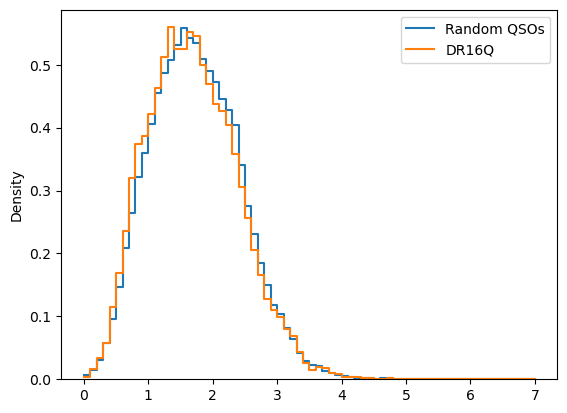

In [5]:
sns.histplot(random_numbers[0:100000],stat="density",fill=False,element="step",binwidth=0.1,binrange=(0,7),color="C0",label="Random QSOs")
sns.histplot(z_arr[0:100000],stat="density",fill=False,element="step",binwidth=0.1,binrange=(0,7),color="C1",label="DR16Q")
pl.legend()

In [6]:
random_numbers.shape

(10000000,)

## 利用healpix生成在天球上均匀分布的随机坐标

In [89]:


# Specify the number of data points you want
num_points = int(100000000/2)

# Set the resolution parameter for the HEALPix map
nside = 2048*2

# Generate random pixel indices
pixel_indices = np.random.choice(hp.nside2npix(nside), num_points, replace=False)

# Convert pixel indices to celestial coordinates (RA, Dec)
a_tmp, b_tmp = hp.pix2ang(nside, pixel_indices, lonlat=True)
mask = (b_tmp > -15) & (b_tmp < 90)
a = a_tmp[mask]
b = b_tmp[mask]

# Print the generated data points
# for i in range(num_points):
#     print(f"Data Point {i+1}: RA = {ra[i]:.2f}°, Dec = {dec[i]:.2f}°")


In [91]:
a.shape,b.shape

((31475385,), (31475385,))

## 利用healpix把选择随机坐标中落在DR16Q中的那些点

In [92]:
#step1: 把DR16Q放入到healpix格子中
nside = 64
pixel_indices_dr16q = hp.ang2pix(nside,  ra_arr, dec_arr, lonlat=True)
pixel_indices_dr16q = np.unique(pixel_indices_dr16q)

In [93]:
pixel_indices_dr16q.shape

(13634,)

In [106]:
#step2: 把随机的源放入到healpix格子中
pixel_indices_randomq = hp.ang2pix(nside,  a, b, lonlat=True)

In [107]:
#step3: 逐一检查pixel_indices_randomq中所有的格子，看是否在pixel_indices_dr16q中

In [108]:
def get_flags(a, b):
    b_set = set(b)  # Create a hash set of elements in b for fast membership check
    flags = []
    
    for element in a:
        flags.append(element in b_set)
    
    return flags

In [109]:
flags=get_flags(pixel_indices_randomq, pixel_indices_dr16q)

In [110]:
#step4: 保存那些flag等于True的

In [111]:
random_ra  = a[flags]
random_dec = b[flags]

In [112]:
random_ra.shape

(13860246,)

## 检查

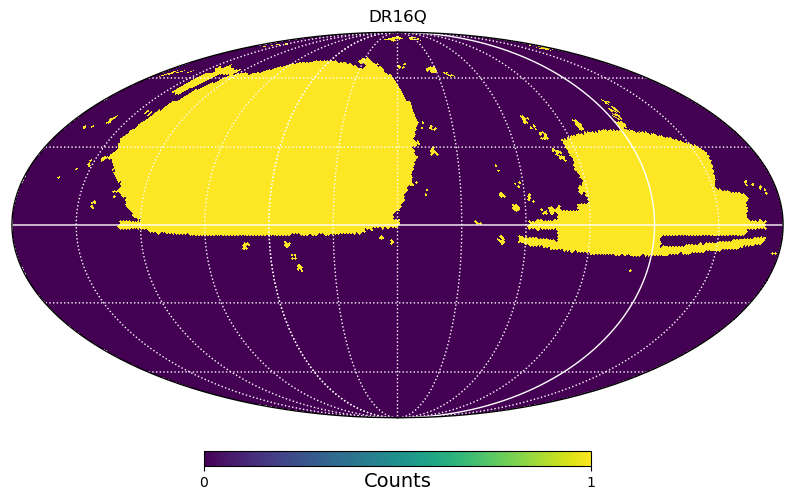

In [114]:
pl.figure(figsize=(10,8))
# Set the resolution parameter for the HEALPix map
nside = 64

# Convert celestial coordinates to HEALPix pixel indices
pixel_indices = hp.ang2pix(nside,  ra_arr, dec_arr, lonlat=True)

# Create an empty HEALPix map and fill it with the pixel indices
hp_map = np.zeros(hp.nside2npix(nside))
np.add.at(hp_map, pixel_indices_dr16q, 1)

hp.mollview(hp_map, title='DR16Q', unit='Counts', hold=True , rot=(120., 0.))
# Plot the HEALPix map with grid lines and coordinate labels
hp.graticule(color="white")




# Show the RA and Dec grid lines and labels
# hp.projtext(0, np.pi / 2, 'Dec = 90°', lonlat=True, ha='center', va='bottom')
# hp.projtext(0, -np.pi / 2, 'Dec = -90°', lonlat=True, ha='center', va='top')
# hp.projtext(np.pi, 0, 'RA = 180°', lonlat=True, ha='right', va='center')
# hp.projtext(0, 0, 'RA = 0°', lonlat=True, ha='left', va='center')

# Show the plot
pl.show()


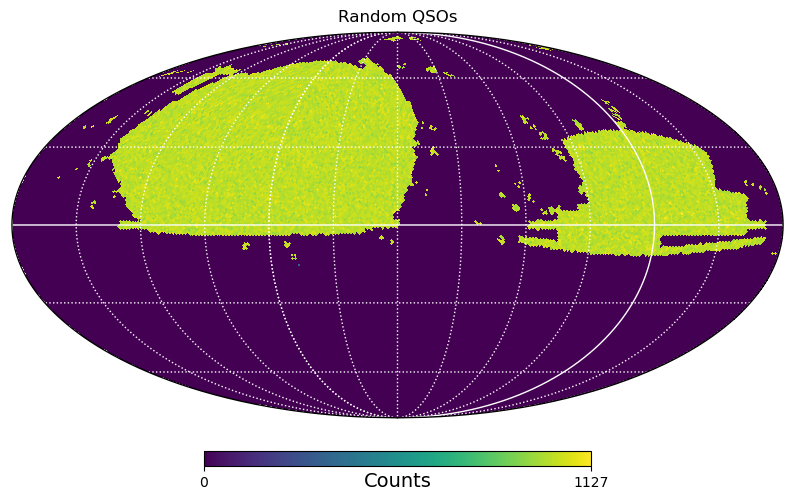

In [115]:
pl.figure(figsize=(10,8))
# Set the resolution parameter for the HEALPix map
nside = 64


# Convert celestial coordinates to HEALPix pixel indices
pixel_indices = hp.ang2pix(nside, random_ra, random_dec, lonlat=True)

# Create an empty HEALPix map and fill it with the pixel indices
hp_map = np.zeros(hp.nside2npix(nside))
np.add.at(hp_map, pixel_indices, 1)

hp.mollview(hp_map, title='Random QSOs', unit='Counts', hold=True , rot=(120., 0.))
# Plot the HEALPix map with grid lines and coordinate labels
hp.graticule(color="white")




# Show the RA and Dec grid lines and labels
# hp.projtext(0, np.pi / 2, 'Dec = 90°', lonlat=True, ha='center', va='bottom')
# hp.projtext(0, -np.pi / 2, 'Dec = -90°', lonlat=True, ha='center', va='top')
# hp.projtext(np.pi, 0, 'RA = 180°', lonlat=True, ha='right', va='center')
# hp.projtext(0, 0, 'RA = 0°', lonlat=True, ha='left', va='center')

# Show the plot
pl.show()


## 保存

In [121]:
# Make ra,dec and Z have the same length
idx=r.sample(range(0,len(random_ra)),len(random_numbers));

# Create the FITS table columns
ra_col = fits.Column(name='RA', format='D', array=random_ra[idx])
dec_col = fits.Column(name='DEC', format='D', array=random_dec[idx])
redshift_col = fits.Column(name='z', format='D', array=random_numbers)

# Create the FITS table HDU
cols = fits.ColDefs([ra_col, dec_col, redshift_col])
hdu = fits.BinTableHDU.from_columns(cols)

# Set the column titles
hdu.header['TTYPE1'] = 'RA'
hdu.header['TTYPE2'] = 'DEC'
hdu.header['TTYPE3'] = 'Z'

# Save the FITS file
hdu.writeto('randomQSO_ra_dec_Z.fits', overwrite=True)


In [90]:
#这是第二种方法，查找在DR16Q中是否存在指定距离小于distance_threshold的点。如果有，就标记为True
#这个方法比第一种慢，但是也是可以工作的，以后说不定什么时候能用上

In [55]:
from sklearn.neighbors import BallTree

def find_close_points(x, y, a, b, distance_threshold):
    # Convert celestial coordinates from degrees to radians
    x_rad = np.radians(x)
    y_rad = np.radians(y)
    a_rad = np.radians(a)
    b_rad = np.radians(b)

    # Create a BallTree from (x, y) data
    xy_data = np.column_stack((np.cos(y_rad) * np.cos(x_rad), np.cos(y_rad) * np.sin(x_rad), np.sin(y_rad)))
    xy_tree = BallTree(xy_data, leaf_size=40)

    # Convert (a, b) data to the same format as (x, y) for the query
    ab_data = np.column_stack((np.cos(b_rad) * np.cos(a_rad), np.cos(b_rad) * np.sin(a_rad), np.sin(b_rad)))

    # Perform the nearest neighbor query
    _, indices = xy_tree.query_radius(ab_data, distance_threshold / 3600, return_distance=True)

    # Create flags indicating whether a close point was found
    flags = np.array([len(indices[i]) > 0 for i in range(len(ab_data))], dtype=bool)

    return flags

# Example usage
# x = np.random.uniform(low=0, high=360, size=750000)
# y = np.random.uniform(low=-90, high=90, size=750000)
# a = np.random.uniform(low=0, high=360,  size=30000000)
# b = np.random.uniform(low=-15, high=75, size=30000000)
distance_threshold = 20  # in arcsec

flags = find_close_points(ra_arr, dec_arr, a[0:30000000], b[0:30000000], distance_threshold)
# print(flags)


In [60]:
random_ra=tmp1[flags]
random_dec=tmp2[flags]